<a href="https://colab.research.google.com/github/sharma18b/Image-Captioning/blob/main/VGG16_%2B_LSTM_%2B%20Attention%20ASSAMESE__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
!pip install kaggle
os.environ['KAGGLE_CONFIG_DIR']='/content/'

In [2]:
!kaggle datasets download -d 'hsankesara/flickr-image-dataset'

100% 8.15G/8.16G [02:59<00:00, 50.8MB/s]
100% 8.16G/8.16G [02:59<00:00, 48.9MB/s]


In [3]:
!unzip  flickr-image-dataset

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5362687336.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

NameError: ignored

In [4]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [5]:
# Download caption annotation files
annotation_folder = '/flickr30k_images/'
# Download image files
image_folder = '/flickr30k_images/flickr30k_images/'
PATH = os.path.abspath('.') + image_folder

In [6]:
dir_Flickr_text = "/content/flickr30k_images/results.csv"

In [7]:
import pandas as pd

In [8]:
df_AS=pd.read_csv('Flickr30K_EN_AS_final.csv',sep='|', names=('ID','capNO','capEN','capAS'))

In [9]:
colx = list()
for col in df_AS.columns:
  colx.append(col);
  print(col)

ID
capNO
capEN
capAS


In [10]:
print(colx[:4])

['ID', 'capNO', 'capEN', 'capAS']


In [11]:
total_captions_in_f30k = len(df_AS['ID'])
print(total_captions_in_f30k)

158915


In [12]:
print((df_AS['capAS'][0]))

 চোঁচৰা চুলি থকা দুজন ডেকা মানুহে গজত ওলাই থাকোঁতে তেওঁলোকৰ হাতলৈ চাওঁক।


In [13]:
image_path_to_caption = collections.defaultdict(list)
for val in range(len(df_AS)):
  caption = f"<start> {df_AS['capAS'][val]} <end>"
  image_path = PATH + df_AS['ID'][val]
  image_path_to_caption[image_path].append(caption)

In [14]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:8000]
print(len(train_image_paths))

8000


In [15]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start>  জিন্স আৰু নীলা চাৰ্টৰ সৈতে গছত দীঘল চুলি ৰখা ছোৱালী এজনী আছে। <end>


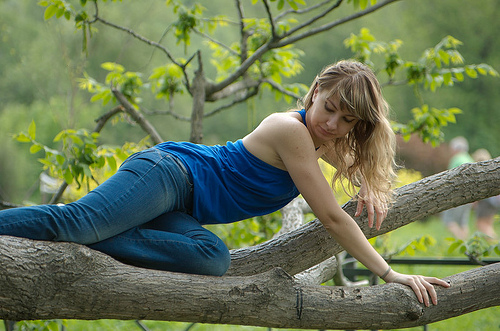

In [16]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [17]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [18]:

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [19]:
from tqdm import tqdm
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 500/500 [04:22<00:00,  1.91it/s]


In [20]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [21]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [22]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [23]:
print(train_captions[:3])
print(train_seqs[:3])

['<start>  জিন্স আৰু নীলা চাৰ্টৰ সৈতে গছত দীঘল চুলি ৰখা ছোৱালী এজনী আছে। <end>', '<start>  নীলা চাৰ্ট পিন্ধা এগৰাকী সোনালী মহিলাই গছৰ ডালত পোজ দি আছে। <end>', '<start>  জিন্স পিন্ধা এগৰাকী মহিলা আৰু গছত নীলা টেংক টপ পৰিআছে। <end>']
[[2, 148, 7, 24, 701, 16, 558, 140, 122, 154, 67, 37, 4, 3], [2, 24, 17, 8, 11, 121, 18, 141, 2682, 233, 111, 4, 3], [2, 148, 8, 11, 35, 7, 558, 24, 334, 199, 1, 3]]


In [24]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

#Splitting 

In [25]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [26]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

In [27]:
print('image _ name _ train ' )
print(img_name_train[0:3])
print('cap _ train ' )
print(cap_train[0:3])
print('image _ name _ val ' )
print(img_name_val[0:3])
print('cap _ train ' )
print(cap_val[0:3])

image _ name _ train 
['/content/flickr30k_images/flickr30k_images/1549878731.jpg', '/content/flickr30k_images/flickr30k_images/1549878731.jpg', '/content/flickr30k_images/flickr30k_images/1549878731.jpg']
cap _ train 
[array([  2,   5, 101, 579, 338, 258,  38,   5, 315,  88, 238, 268, 433,
         7,  96, 612, 579, 338, 258, 421,   5,  49, 124,   3,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32), array([   2,    5,   31,  579,  338, 1760,   38,    5,   83,   78, 2232,
         30,    4,    3,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,   

In [28]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49


# BATCH_SIZE = 64
# BUFFER_SIZE = 1000
# embedding_dim = 256
# units = 512
# vocab_size = top_k + 1
# num_steps = len(img_name_train) // BATCH_SIZE
# # Shape of the vector extracted from InceptionV3 is (64, 2048)
# # These two variables represent that vector shape
# features_shape = 2048
# attention_features_shape = 64

In [29]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [30]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

#Model Design 

In [31]:
class VGG16_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [32]:
def rnn_type(units):
   if True:
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

In [33]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)


In [34]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [35]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [36]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

#Training

In [37]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [38]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [39]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.7622
Epoch 1 Batch 100 Loss 0.9281
Epoch 1 Batch 200 Loss 0.8877
Epoch 1 Batch 300 Loss 0.8360
Epoch 1 Batch 400 Loss 0.6843
Epoch 1 Loss 0.897261
Time taken for 1 epoch 501.99 sec

Epoch 2 Batch 0 Loss 0.6862
Epoch 2 Batch 100 Loss 0.7642
Epoch 2 Batch 200 Loss 0.7110
Epoch 2 Batch 300 Loss 0.6997
Epoch 2 Batch 400 Loss 0.7193
Epoch 2 Loss 0.730534
Time taken for 1 epoch 399.66 sec

Epoch 3 Batch 0 Loss 0.6684
Epoch 3 Batch 100 Loss 0.6349
Epoch 3 Batch 200 Loss 0.6875
Epoch 3 Batch 300 Loss 0.6822
Epoch 3 Batch 400 Loss 0.7585
Epoch 3 Loss 0.683656
Time taken for 1 epoch 399.57 sec

Epoch 4 Batch 0 Loss 0.6411
Epoch 4 Batch 100 Loss 0.6736
Epoch 4 Batch 200 Loss 0.7160
Epoch 4 Batch 300 Loss 0.6464
Epoch 4 Batch 400 Loss 0.6679
Epoch 4 Loss 0.651590
Time taken for 1 epoch 400.46 sec

Epoch 5 Batch 0 Loss 0.6945
Epoch 5 Batch 100 Loss 0.6243
Epoch 5 Batch 200 Loss 0.5940
Epoch 5 Batch 300 Loss 0.6306
Epoch 5 Batch 400 Loss 0.5630
Epoch 5 Loss 0.627868
Time taken

In [56]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [57]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> এজন মানুহে ড্ৰাম বজাই আছে। <end>
Prediction Caption: <unk> বৈদ্যুতিক <unk> এজন মানুহ এজন মানুহ। <end>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2504 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2470 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2479 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2497 missing from current font.
  font.set_text(s

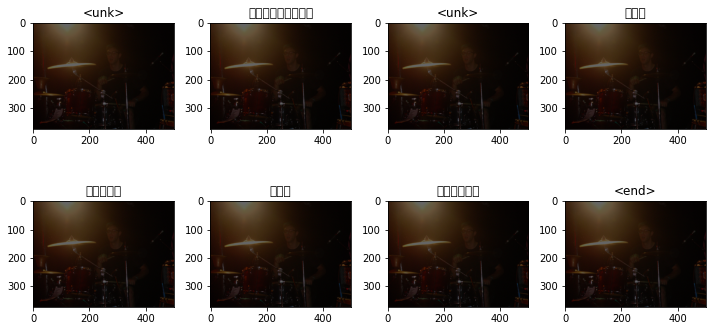

In [58]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [59]:
decoder.save_weights('decoder.h5')
encoder.save_weights('encoder.h5')
image_features_extract_model.save_weights('image_features_extract_model.h5')


In [ ]:
from google.colab import files
files.download('/content/decoder.h5')
files.download('/content/encoder.h5')
files.download('/content/image_features_extract_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [61]:

my_model_captions = dict()
for z in tqdm(range(1000)): # set higher to see more examples
  #plt.imshow(x)
  #plt.show()
  result, attention_plot = evaluate(image_paths[8000 + z])
  #p = generateCaption(image)
  my_model_captions[image_paths[8000 + z]] = result
  #print("Caption:",generateCaption(image))
  #print("_____________________________________")



100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]


In [62]:
given_captions = dict()
for z in tqdm(range(1000)): # set higher to see more examples
  #plt.imshow(x)
  #plt.show()
  result = image_path_to_caption[image_paths[8000 + z]]
  #p = generateCaption(image)
  given_captions[image_paths[8000 + z]] = result

100%|██████████| 1000/1000 [00:00<00:00, 97439.98it/s]


In [63]:
import pickle
a_file = open("my_gen_cap.pkl", "wb")
pickle.dump(my_model_captions, a_file)
a_file.close()
b_file = open("given_cap.pkl", "wb")
pickle.dump(given_captions, b_file)
b_file.close()

In [64]:
from nltk.translate.bleu_score import corpus_bleu
act, predict = list(), list()
def evaluate_model():
  for key,value in my_model_captions.items():
    pred = my_model_captions[key];
    ref = given_captions[key];
    references = [d.split() for d in ref];
    act.append(references);
    predict.append(pred);
  print('BLEU-1: %f' % corpus_bleu(act, predict, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(act, predict, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(act, predict, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(act, predict, weights=(0.25, 0.25, 0.25, 0.25)))
  

In [65]:
evaluate_model()

BLEU-1: 0.294598
BLEU-2: 0.155684
BLEU-3: 0.097728
BLEU-4: 0.036322


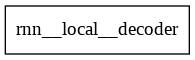

In [69]:
dot_img_file = '/content/model_1.png'
tf.keras.utils.plot_model(decoder, to_file=dot_img_file, show_shapes=True)

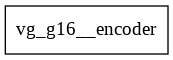

In [70]:
from keras.utils.vis_utils import plot_model
plot_model(encoder, to_file='model_plot_encoder.png', show_shapes=True, show_layer_names=True)

In [71]:
encoder.summary()

Model: "vg_g16__encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  131328    
_________________________________________________________________
dropout (Dropout)            multiple                  0 (unused)
Total params: 131,328
Trainable params: 131,328
Non-trainable params: 0
_________________________________________________________________


In [72]:
decoder.summary()

Model: "rnn__local__decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  4446720   
_________________________________________________________________
gru (GRU)                    multiple                  1575936   
_________________________________________________________________
dense_1 (Dense)              multiple                  262656    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  2048      
_________________________________________________________________
dense_2 (Dense)              multiple                  8910810   
_________________________________________________________________
dense_3 (Dense)              multiple          

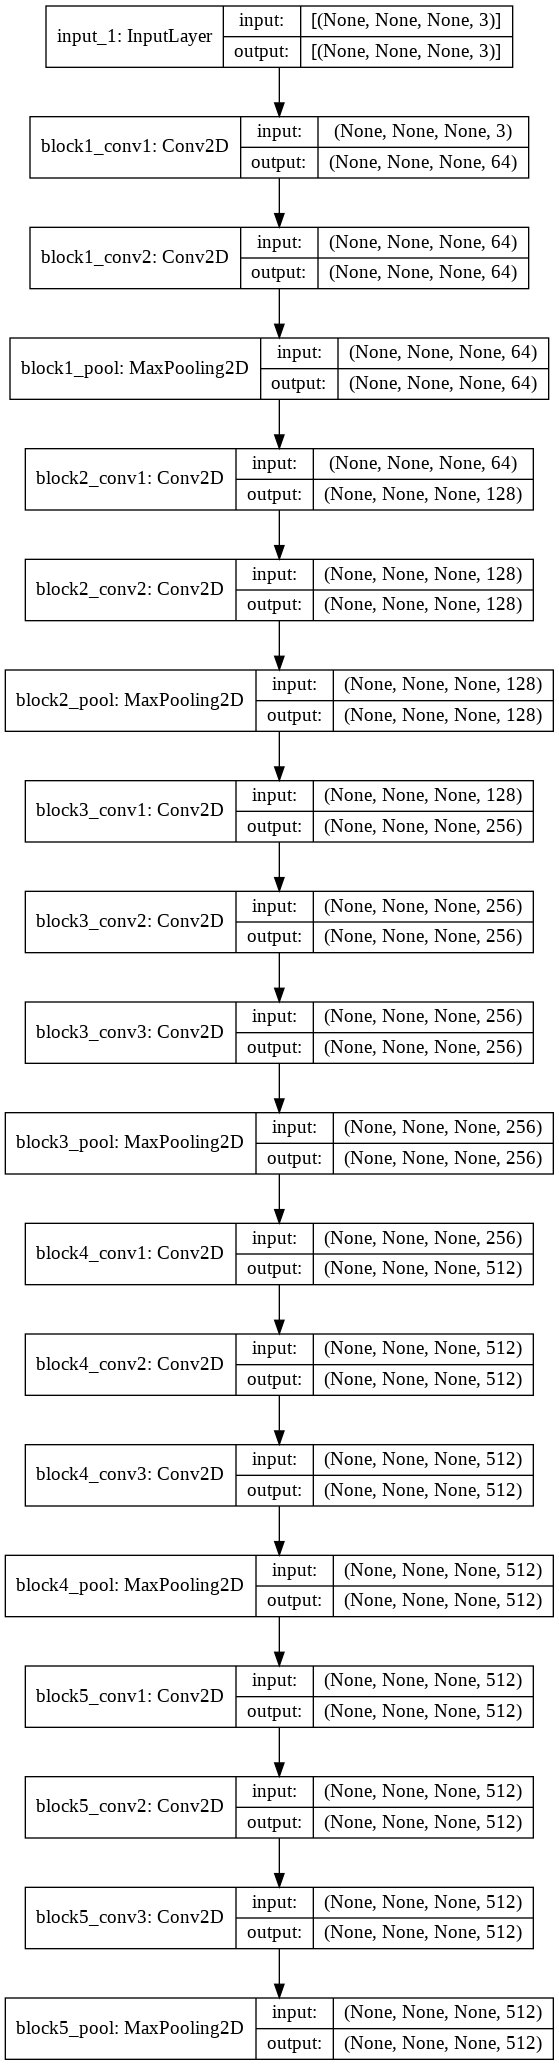

In [73]:
plot_model(image_features_extract_model, to_file='model_plot_image.png', show_shapes=True, show_layer_names=True)